In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from scipy.stats import multivariate_normal, bernoulli, beta, norm

In [36]:
data = pd.read_csv('../Data/CVD_cleaned.csv')

In [37]:
display(data.head())

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


## Visualise the entire data, with one singular plot per column in the dataset:

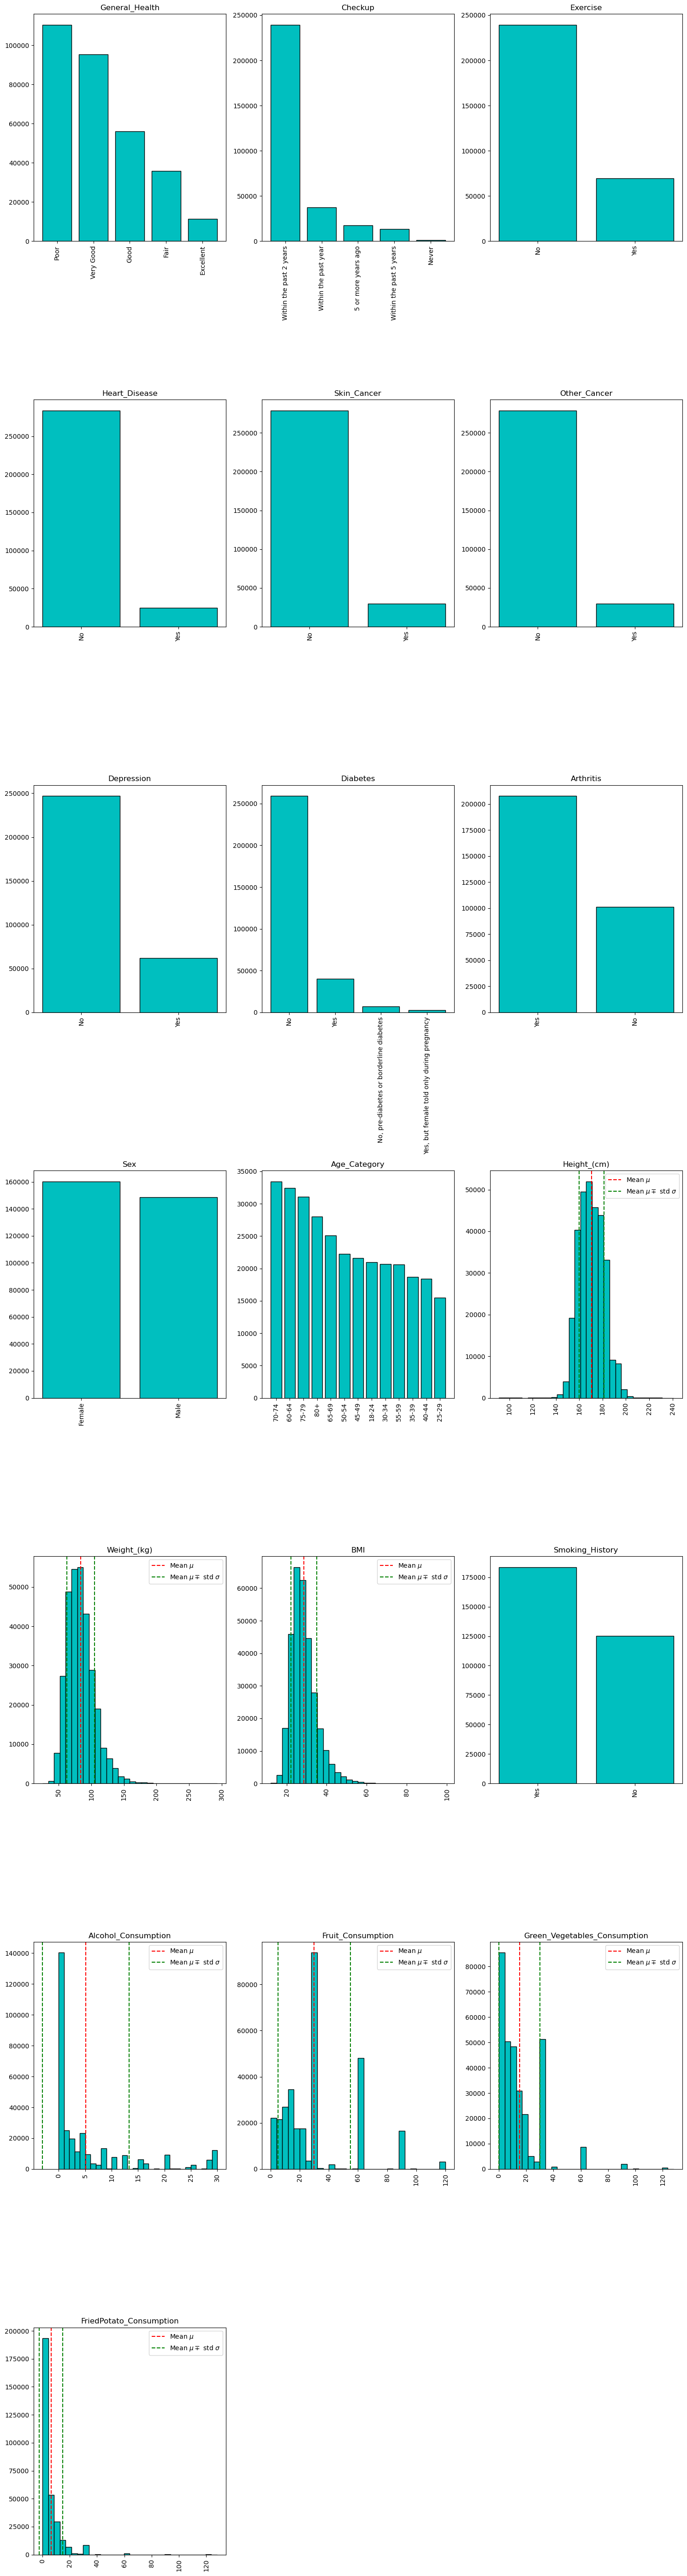

In [38]:
def plot_data_columns(data: pd.DataFrame) -> None:
    """Plot the columns of a dataframe, where every
    column is plotted as a single histogram or bar plot.
    A column with only 0 or 1 as its values is plotted
    as a bar plot and will get ticks 'Yes' or 'No'.

    Args:
        data (pd.DataFrame): any pandas dataframe.
    """
    plots_per_row = 3
    num_cols = len(data.columns)
    num_rows = np.ceil(num_cols / plots_per_row).astype(int)

    # Figsize is hand picked
    fig = plt.figure(figsize=(15, 8 * num_rows))

    for i, col in enumerate(data.columns):
        ax = fig.add_subplot(num_rows, plots_per_row, i + 1)

        # If everything is numbers, we make a histogram
        if all([isinstance(x, (int, float)) for x in data[col]]):
            ax.hist(data[col], bins=30, edgecolor='k', color='c')
            m = np.mean(data[col])
            s = np.std(data[col])
            ax.axvline(m, color='red', linestyle='--', label=fr'Mean $\mu$')
            ax.axvline(m + s, color='green', linestyle='--', label=fr'Mean $\mu \mp $ std $\sigma$')
            ax.axvline(m - s, color='green', linestyle='--')
            ax.legend()
            
        else:
        # Otherwise it must be a bar plot
            ax.bar(data[col].unique(), data[col].value_counts(), edgecolor='k', color='c')
            # Check if only 0 and 1, then we must change the ticks
            if all([x in [0, 1] for x in data[col]]):
                ax.set_xticks([0, 1])
                ax.set_xticklabels(['No', 'Yes'])
        
        ax.tick_params(axis='x', rotation=90)
        ax.set_title(col)

    plt.tight_layout()
    plt.show()

plot_data_columns(data)

## Now visualise the data for only females:

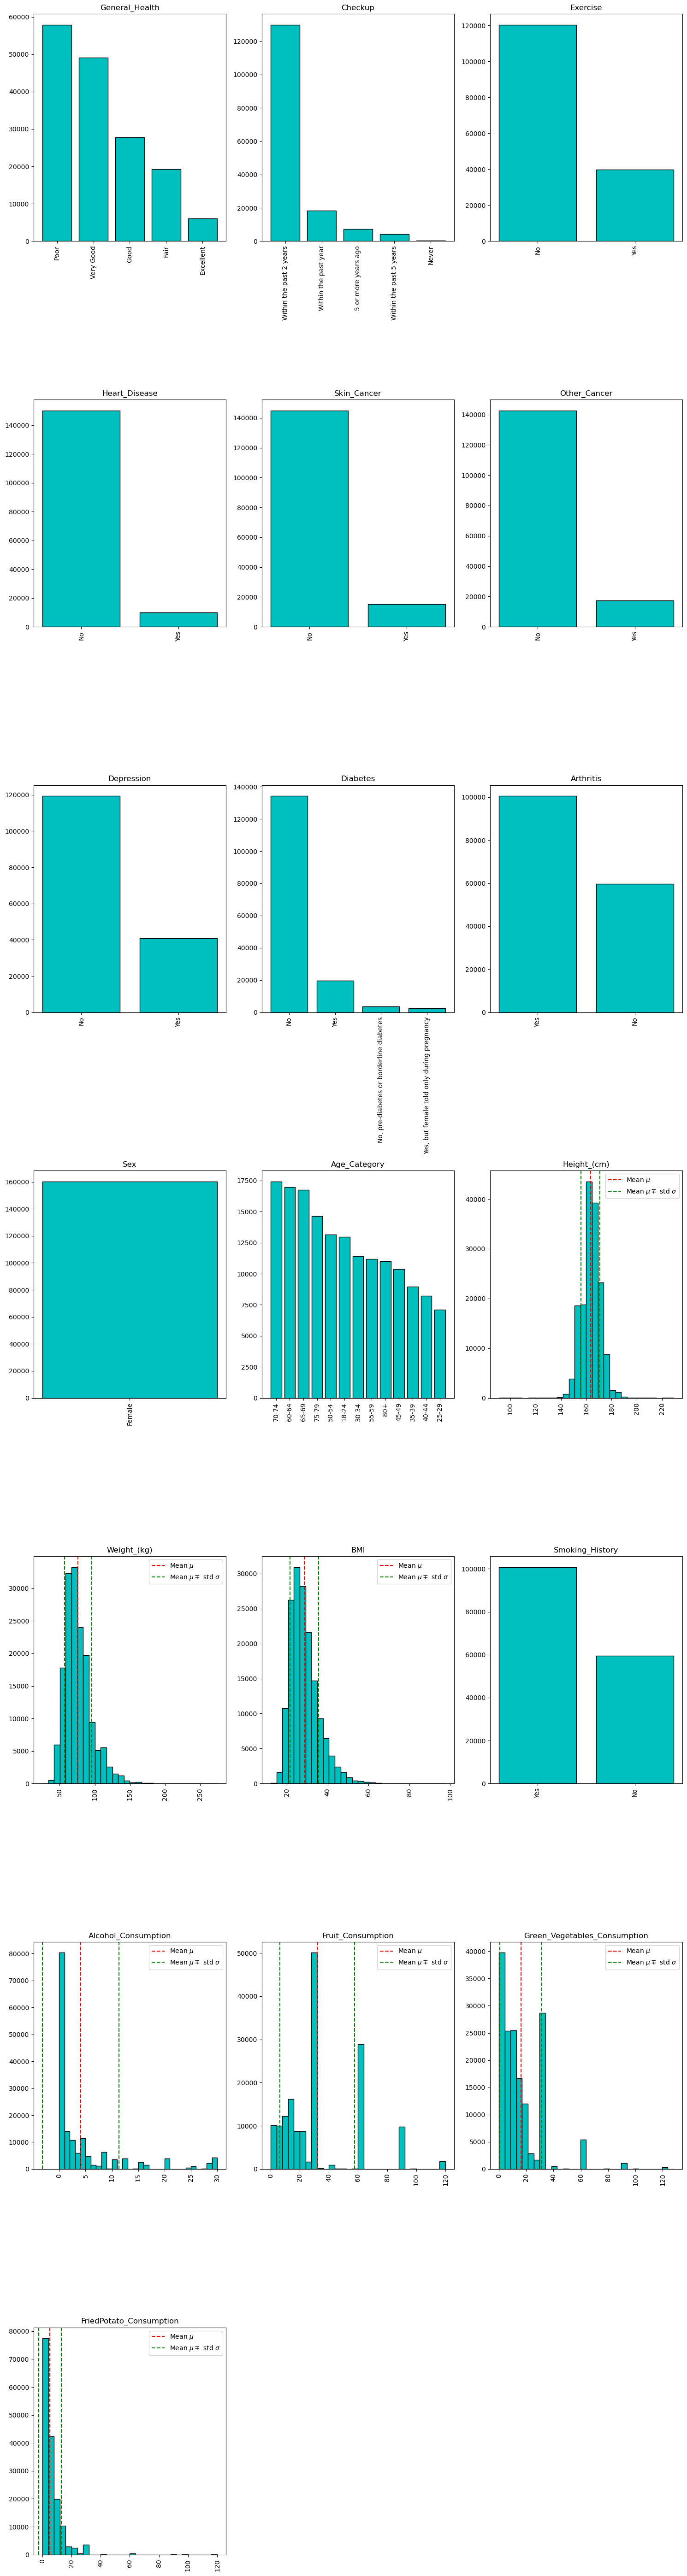

In [39]:
plot_data_columns(data.loc[data["Sex"] == "Female"])

## Now visualise the data for only males:

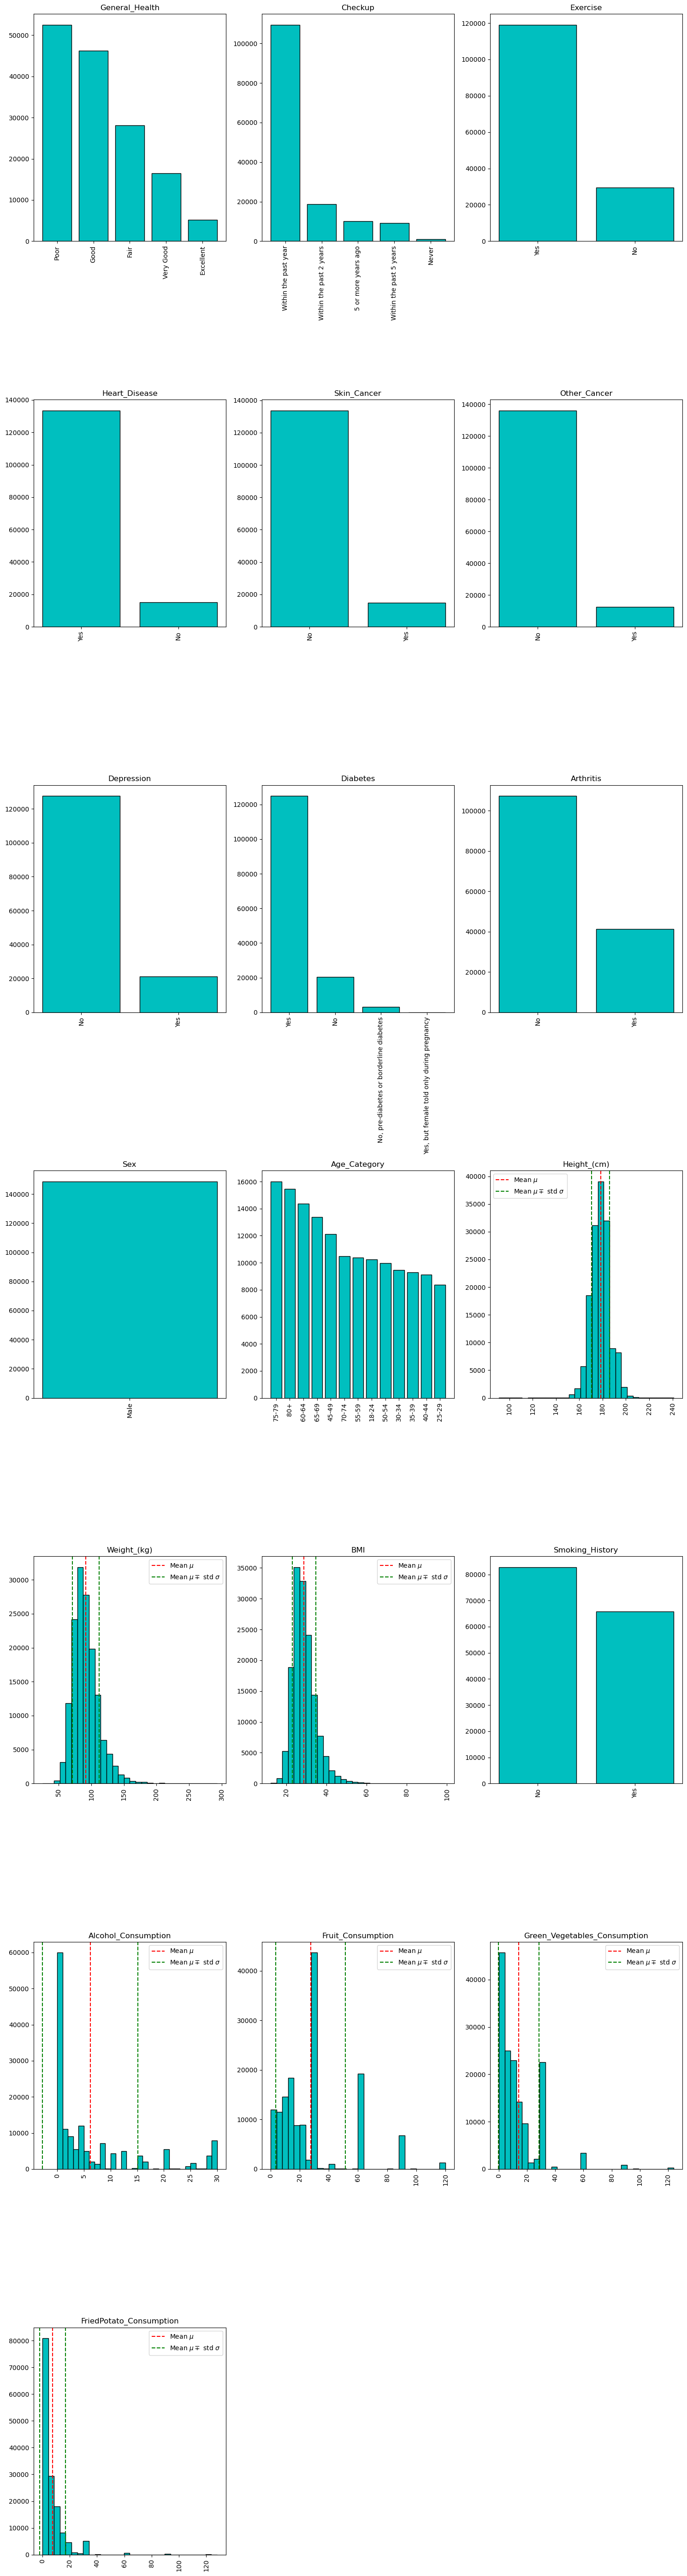

In [40]:
plot_data_columns(data.loc[data["Sex"] == "Male"])

## The correlation matrix for our dataset:

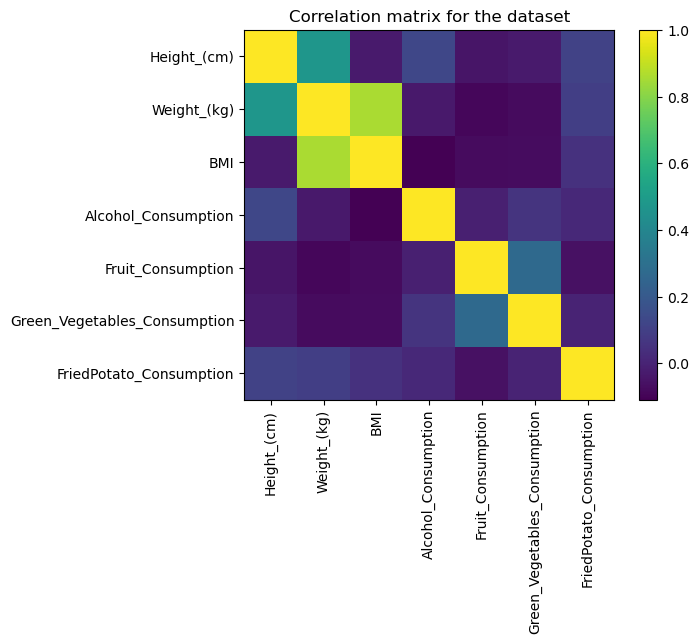

In [41]:
# For the correlation we can only take columns with numbers
data_num = data.select_dtypes(include=[int, float])
corr = data_num.corr()

plt.imshow(corr, cmap='viridis')
plt.colorbar()
plt.xticks(np.arange(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(np.arange(len(corr.columns)), corr.columns)
plt.title('Correlation matrix for the dataset')
plt.show()

## Reformatting the data for logistic regression

In [42]:
# reformatting the data to be suitable for logistic regression
# transforming categorical variables (Yes=1, No=0)
# transforming 'Sex' variable to binary 'Sex_Male' variable
data = data.replace({'Skin_Cancer':'Yes', 'Other_Cancer': 'Yes', 'Heart_Disease': 'Yes', 'Depression': 'Yes', 'Smoking_History': 'Yes', 'Exercise': 'Yes'
                     , 'Sex': 'Male', 'Arthritis': 'Yes'}, 1).replace({'Skin_Cancer':'No', 'Other_Cancer': 'No', 'Heart_Disease': 'No'
                                                   , 'Depression': 'No', 'Smoking_History': 'No', 'Exercise': 'No'
                                                   , 'Sex': 'Female', 'Arthritis': 'No'}, 0).rename(columns={'Sex':'Sex_Male'})

/tmp/ipykernel_37754/1477871690.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  , 'Sex': 'Male', 'Arthritis': 'Yes'}, 1).replace({'Skin_Cancer':'No', 'Other_Cancer': 'No', 'Heart_Disease': 'No'


In [43]:
data.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex_Male,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,0,0,0,0,0,No,1,0,70-74,150.0,32.66,14.54,1,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,0,1,0,0,0,Yes,0,0,70-74,165.0,77.11,28.29,0,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,1,0,0,0,0,Yes,0,0,60-64,163.0,88.45,33.47,0,4.0,12.0,3.0,16.0
3,Poor,Within the past year,1,1,0,0,0,Yes,0,1,75-79,180.0,93.44,28.73,0,0.0,30.0,30.0,8.0
4,Good,Within the past year,0,0,0,0,0,No,0,1,80+,191.0,88.45,24.37,1,0.0,8.0,4.0,0.0


## Checking columns with multiple categories

In [44]:
print(data['Age_Category'].unique())

['70-74' '60-64' '75-79' '80+' '65-69' '50-54' '45-49' '18-24' '30-34'
 '55-59' '35-39' '40-44' '25-29']


In [45]:
print(data['Diabetes'].unique())

['No' 'Yes' 'No, pre-diabetes or borderline diabetes'
 'Yes, but female told only during pregnancy']


In [46]:
print(data['Checkup'].unique())

['Within the past 2 years' 'Within the past year' '5 or more years ago'
 'Within the past 5 years' 'Never']


In [47]:
print(data['General_Health'].unique())

['Poor' 'Very Good' 'Good' 'Fair' 'Excellent']


## Normalisation of numerical values

In [48]:
# normalize numerical values
def normalize_data(data):
    """
    This function takes a column of data and normalizes it.
    """
    min_value = min(data)
    max_value = max(data)
    normalized_data = []

    for value in data:
        new_value = (value - min_value) / (max_value - min_value)
        normalized_data.append(new_value)

    return normalized_data

# normalise the height (done in such a way that we can interpret an increase in height as a 10 cm increase over the average height)
data['Height_(cm)'] = (data['Height_(cm)']- data['Height_(cm)'].mean())/10
data = data.rename(columns={'Height_(cm)':'Height_norm'})

# normalise the weight (done in such a way that we can interpret an increase in weight as a 5 kg increase over the average weight)
data['Weight_(kg)'] = (data['Weight_(kg)']- data['Weight_(kg)'].mean())/5
data = data.rename(columns={'Weight_(kg)':'Weight_norm'})

# normalise the bmi (done in such a way that we can interpret an increase in bmi as a 1 point increase over the average bmi)
data['BMI'] = (data['BMI']- data['BMI'].mean())
data = data.rename(columns={'BMI':'BMI_norm'})

data.head(10)

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex_Male,Age_Category,Height_norm,Weight_norm,BMI_norm,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,0,0,0,0,0,No,1,0,70-74,-2.061525,-10.185731,-14.086211,1,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,0,1,0,0,0,Yes,0,0,70-74,-0.561525,-1.295731,-0.336211,0,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,1,0,0,0,0,Yes,0,0,60-64,-0.761525,0.972269,4.843789,0,4.0,12.0,3.0,16.0
3,Poor,Within the past year,1,1,0,0,0,Yes,0,1,75-79,0.938475,1.970269,0.103789,0,0.0,30.0,30.0,8.0
4,Good,Within the past year,0,0,0,0,0,No,0,1,80+,2.038475,0.972269,-4.256211,1,0.0,8.0,4.0,0.0
5,Good,Within the past year,0,0,0,0,1,No,1,1,60-64,1.238475,14.126269,17.483789,0,0.0,12.0,12.0,12.0
6,Fair,Within the past year,1,1,0,0,0,No,1,1,60-64,0.438475,-2.747731,-5.886211,1,0.0,16.0,8.0,0.0
7,Good,Within the past year,1,0,0,0,0,No,1,0,65-69,-0.561525,5.054269,11.313789,1,3.0,30.0,8.0,8.0
8,Fair,Within the past year,0,0,0,0,1,No,0,0,65-69,-0.761525,-2.203731,-1.166211,1,0.0,12.0,12.0,4.0
9,Fair,Within the past year,0,0,0,0,0,Yes,1,0,70-74,-0.761525,1.608269,6.043789,0,0.0,12.0,12.0,1.0


## Transforming the remaining columns (multiple categories)

In [49]:
# set age to numerical by taking the mean of the existing categories (ASSUMPTION: 80+ is estimated to 85)
age_mapping = {'18-24': 21.0, '25-29': 27.0, '30-34': 32.0, '35-39': 37.0,'40-44': 42.0, '45-49': 47.0, '50-54': 52.0, 
               '55-59': 57.0,'60-64': 62.0, '65-69': 67.0, '70-74': 72.0, '75-79': 77.0, '80+': 85.0}

# apply the mapping
data['Age_Category'] = data['Age_Category'].map(age_mapping)
data = data.rename(columns={'Age_Category':'Age_Numeric'})

# normalise the age (done in such a way that we can interpret an increase in age as a 10 year increase over the average age)
data['Age_Numeric'] = (data['Age_Numeric']- data['Age_Numeric'].mean())/10
data = data.rename(columns={'Age_Numeric':'Age_Normalised'})

# diabetes transformation
# group all kinds of diabetics together
diabetes_binary = [0 if i == 'No' else 1 for i in data['Diabetes']]
data['Diabetes'] = diabetes_binary
data = data.rename(columns={'Diabetes':'Diabetic'})

# group 'recent' checkups (within past 2 years)
checkup_binary = [1 if i == 'Within the past year' or i == 'Within the past 2 years' else 0 for i in data['Checkup']]
data['Checkup'] = checkup_binary
data = data.rename(columns={'Checkup':'Recent_Checkup'})

# transform perceived health
health_binary = [0 if i == 'Fair' or i == 'Poor' else 1 for i in data['General_Health']]
data['General_Health'] = health_binary
data = data.rename(columns={'General_Health':'Health_Good_or_Better'})

## Dropping consumption columns (without knowing exactly what their contents mean they are useless)

In [50]:
data = data.drop(columns=['Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption'])
data.head()

,Health_Good_or_Better,Recent_Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetic,Arthritis,Sex_Male,Age_Normalised,Height_norm,Weight_norm,BMI_norm,Smoking_History
0,0,1,0,0,0,0,0,0,1,0,1.716472,-2.061525,-10.185731,-14.086211,1
1,1,1,0,1,0,0,0,1,0,0,1.716472,-0.561525,-1.295731,-0.336211,0
2,1,1,1,0,0,0,0,1,0,0,0.716472,-0.761525,0.972269,4.843789,0
3,0,1,1,1,0,0,0,1,0,1,2.216472,0.938475,1.970269,0.103789,0
4,1,1,0,0,0,0,0,0,0,1,3.016472,2.038475,0.972269,-4.256211,1


In [51]:
# TODO
# calculate/plot correlation coefficients

## Plots for the bars/histograms based on if a person has heart disease or not, to possibly see correlations between a variable and heart disease (or not). It shows the difference between the group with and without heart disease.

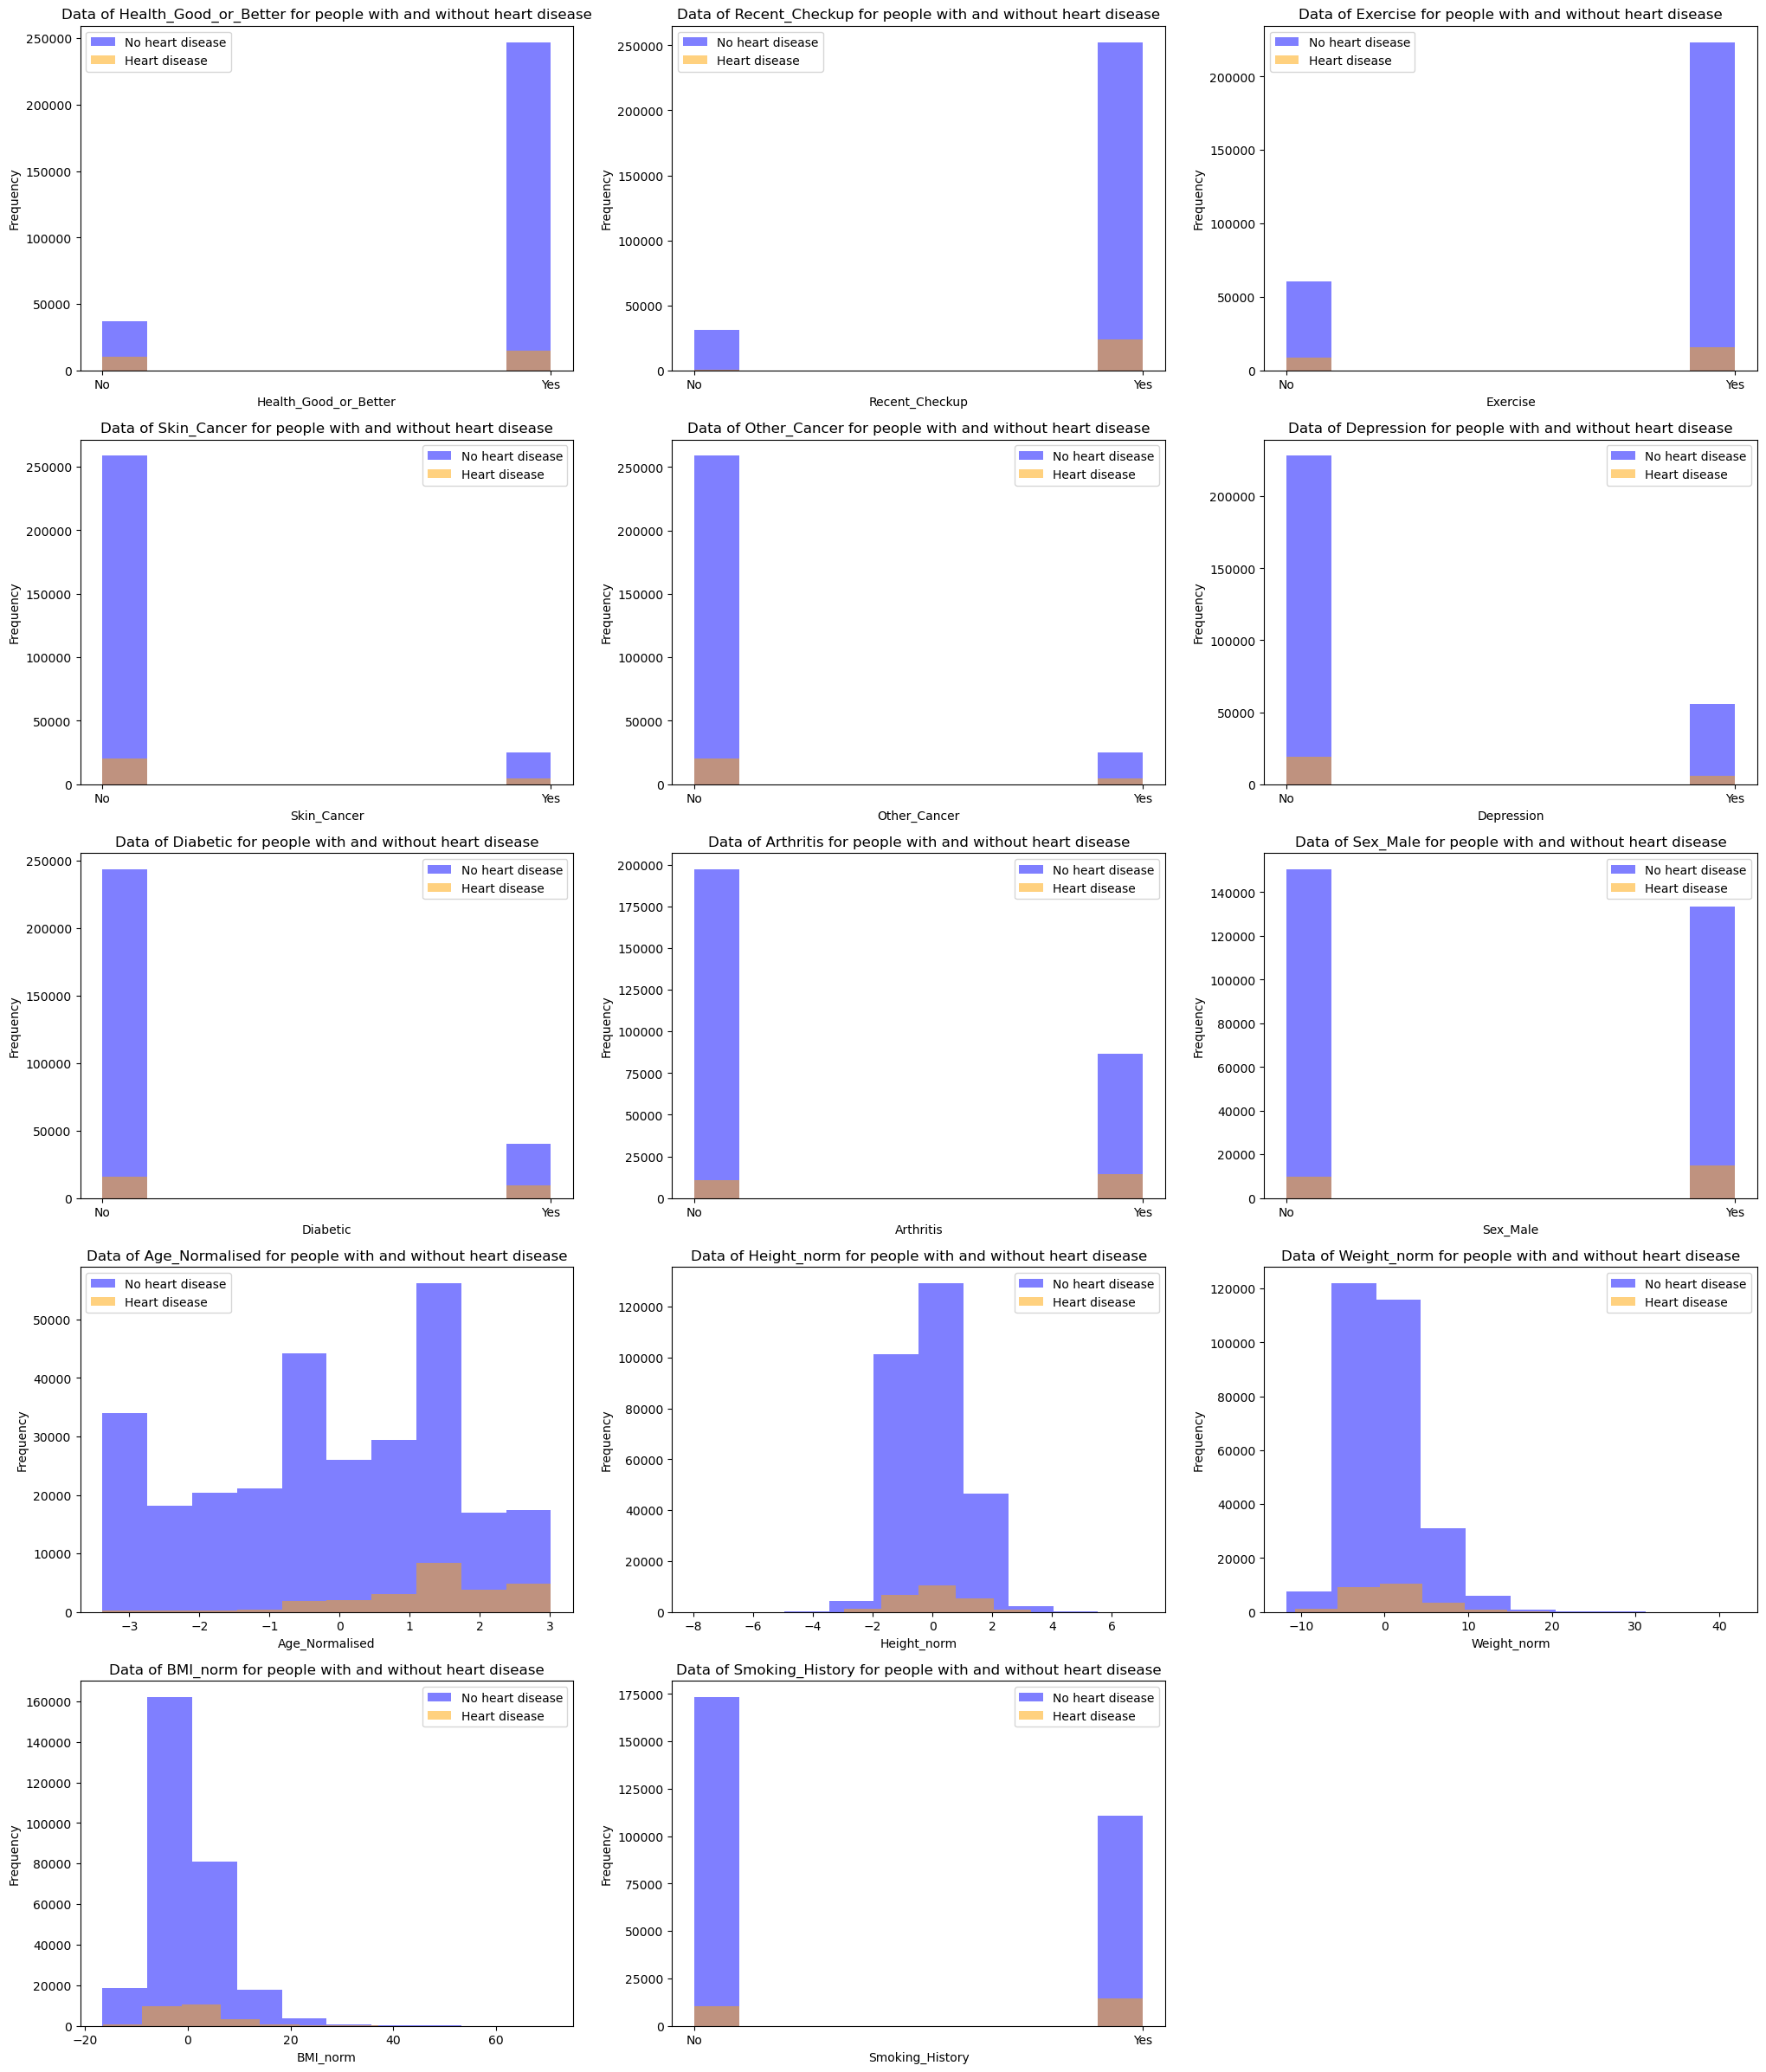

In [52]:
no_heart_disease = data.loc[data["Heart_Disease"] == 0]
heart_disease = data.loc[data["Heart_Disease"] == 1]

no_heart_disease_y = no_heart_disease["Heart_Disease"] # y vector
heart_disease_y = heart_disease["Heart_Disease"] # y vector

no_heart_disease = no_heart_disease.drop(columns=["Heart_Disease"])
heart_disease = heart_disease.drop(columns=["Heart_Disease"])

fig, axs = plt.subplots(5, 3, figsize=(25, 30))

c = 0
for i in range(14):

    plt.subplot(5, 3, i + 1)
    plt.hist(no_heart_disease[no_heart_disease.columns[i]], label='No heart disease', alpha=0.5, color='b')
    plt.hist(heart_disease[heart_disease.columns[i]], label='Heart disease', alpha=0.5, color='orange')
    plt.xlabel(no_heart_disease.columns[i])
    plt.ylabel('Frequency')
    plt.title(f'Data of {no_heart_disease.columns[i]} for people with and without heart disease')

    unique_vals = no_heart_disease[no_heart_disease.columns[i]].unique()
    if len(unique_vals) == 2 and all([x in [0, 1] for x in unique_vals]):
        plt.xticks([0, 1], ['No', 'Yes'])

    plt.legend()
    c += 1

# remove empty subplot
fig.delaxes(axs[-1, -1])
plt.show()

## Running a basic logistic regression model

In [53]:
# splitting into X and Y and adding a constant
Y = data['Heart_Disease']
X = data.drop(columns='Heart_Disease')
X_intercept = sm.add_constant(X)

# recombining XY
column_names = ['constant']
for i in data.columns:
    column_names.append(i)

XY_constant = pd.DataFrame(np.hstack((np.array(Y)[:, np.newaxis], X_intercept)), columns=column_names)

In [54]:
# splitting into test and train set (25:75)
num_samples = 0.25 * len(XY_constant)
row_ids = list(range(XY_constant.shape[0]))

# randomly select 25% of the row ids
selected_row_ids = random.sample(row_ids, round(num_samples))

# subset to create train and test
data_test = XY_constant.iloc[XY_constant.index.isin(selected_row_ids)]
data_train = XY_constant.iloc[~XY_constant.index.isin(selected_row_ids)]

In [55]:
Y_train = data_train['Heart_Disease']
Y_test = data_test['Heart_Disease']
X_train = data_train.drop(columns='Heart_Disease')
X_test = data_test.drop(columns='Heart_Disease')

In [56]:
model = sm.Logit(Y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.487117
         Iterations 6


In [57]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Heart_Disease   No. Observations:               231640
Model:                          Logit   Df Residuals:                   231625
Method:                           MLE   Df Model:                           14
Date:                Thu, 05 Dec 2024   Pseudo R-squ.:                 0.08563
Time:                        10:31:28   Log-Likelihood:            -1.1284e+05
converged:                       True   LL-Null:                   -1.2340e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
constant                 -0.1539      0.018     -8.487      0.000      -0.189      -0.118
Health_Good_or_Better     0.4886      0.024     20.687      0.000       0.442       0.535
Recent_Checkup            1.0224      0.013     76.191      0.000       0.996       1.049
Exercise                  0.2194      0.018     12.005      0.000       0.184       0.255
Skin_Cancer               0.2330      0.018     12.726      0.000       0.197       0.269
Other_Cancer             -0.0380      0.017     -2.227      0.026      -0.071      -0.005
Depression               -0.1940      0.013    -14.754      0.000      -0.220      -0.168
Diabetic                 -0.2823      0.014    -20.642      0.000      -0.309      -0.256
Arthritis                -0.0980      0.012     -8.214      0.000      -0.121      -0.075
Sex_Male                  0.0642      0.015      4.284      0.000       0.035       0.094
Age_Normalised           -0.1329      0.004    -36.621      0.000      -0.140      -0.126
Height_norm               0.1943      0.021      9.067      0.000       0.152       0.236
Weight_norm              -0.0245      0.010     -2.483      0.013      -0.044      -0.005
BMI_norm                 -0.0269      0.006     -4.776      0.000      -0.038      -0.016
Smoking_History          -0.2712      0.011    -25.154      0.000      -0.292      -0.250
=========================================================================================
"""

In [58]:
# generate predictions
predictions = model.predict(X_test)
# transfrom predictions to binary
prediction_binary = (predictions > 0.5).astype(int)

In [59]:
# compute accuracy score
accuracy = accuracy_score(y_true = Y_test, y_pred = prediction_binary)
print(accuracy)

0.7818141787758697


### Simulating the coefficients

In [60]:
# extract the coefficients and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()
# number of simulations
n_simulations = 10000

# simulate coefficients
simulated_betas = multivariate_normal.rvs(mean = beta_mean, cov = beta_cov, size = n_simulations)

# derive odds from log-odds coefficients 
simulated_betas_odds = np.exp(simulated_betas)

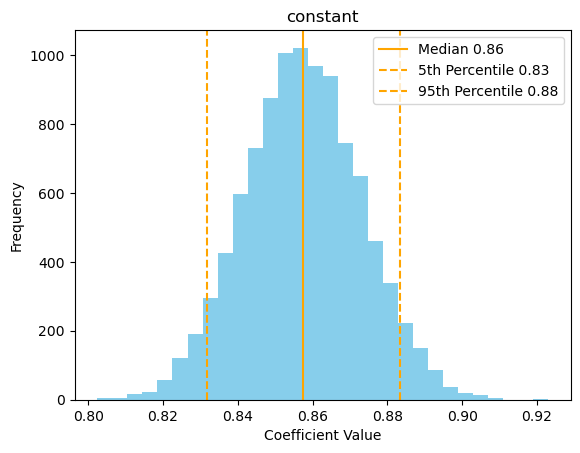

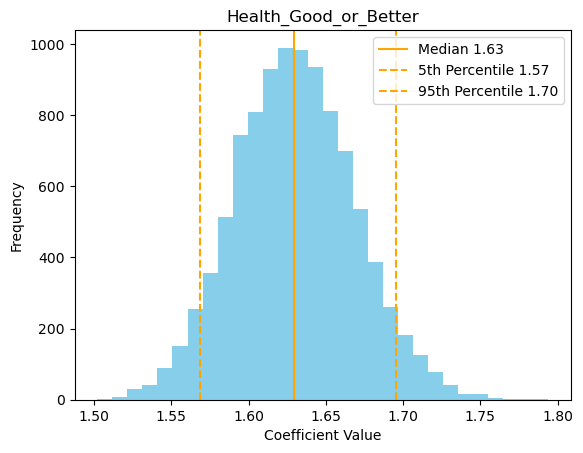

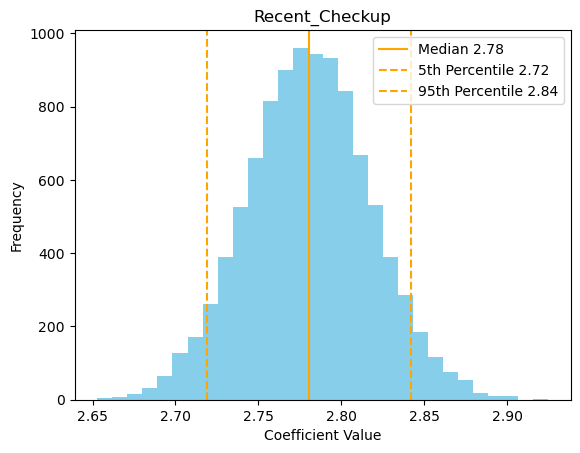

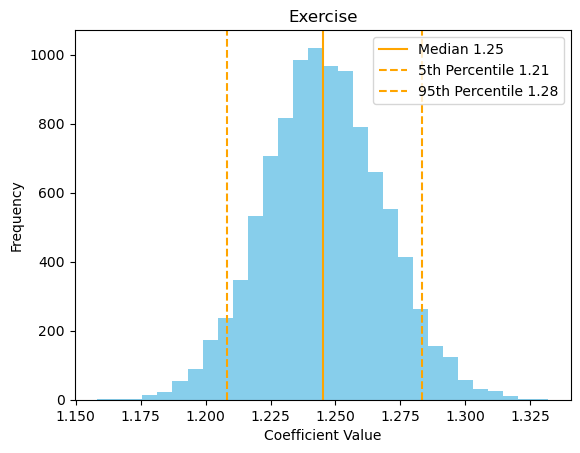

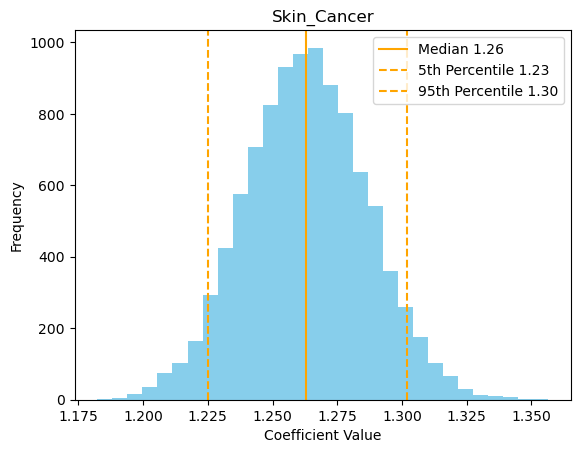

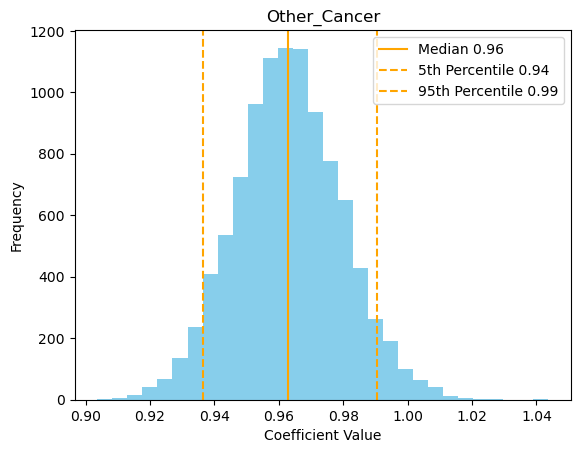

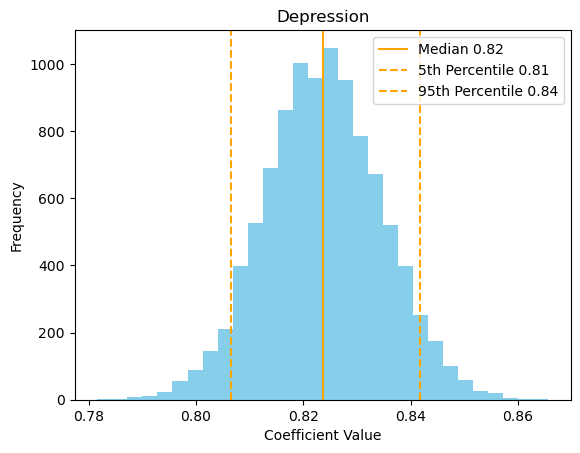

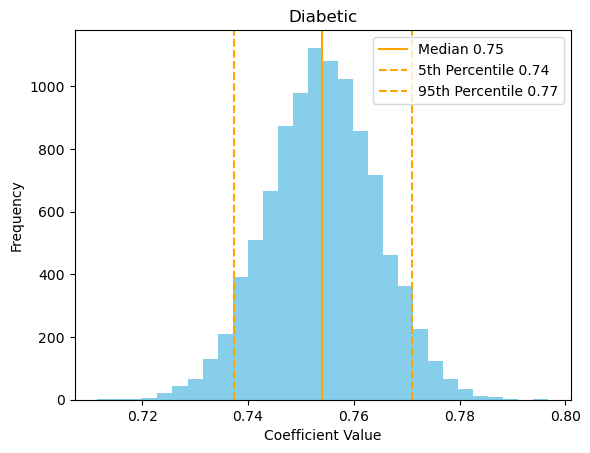

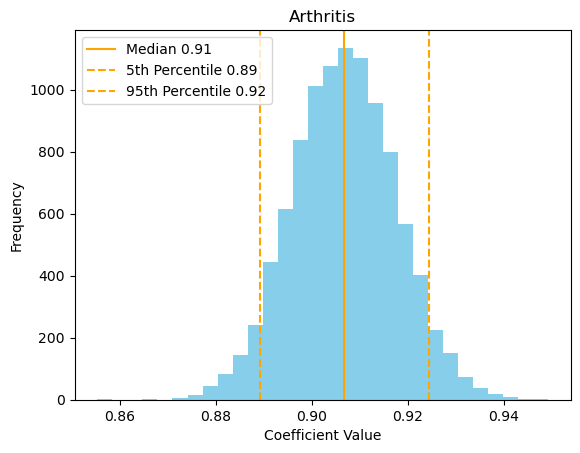

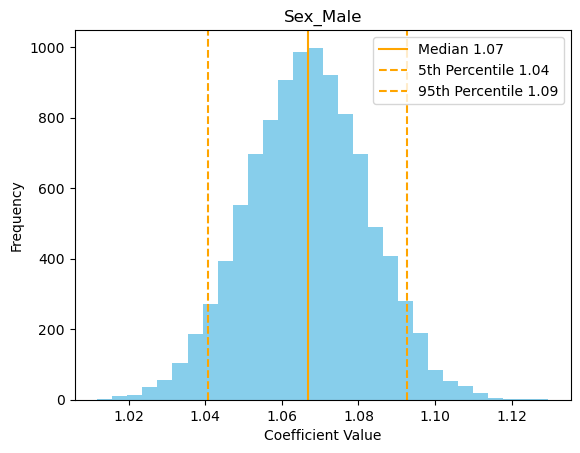

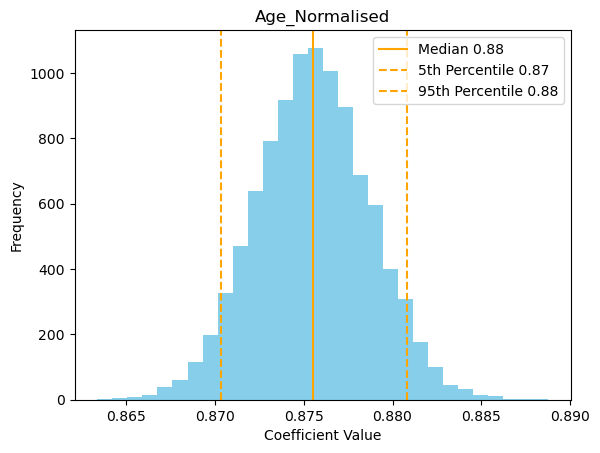

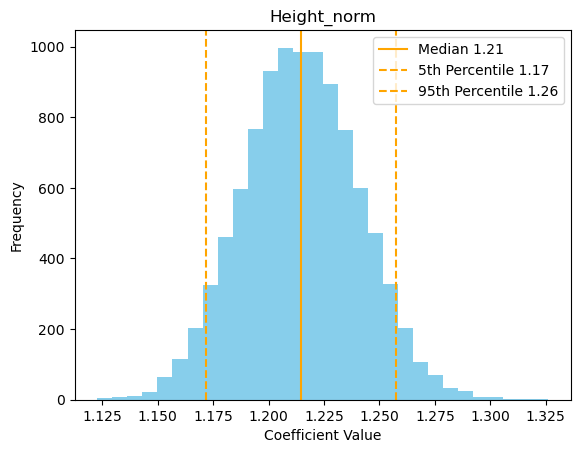

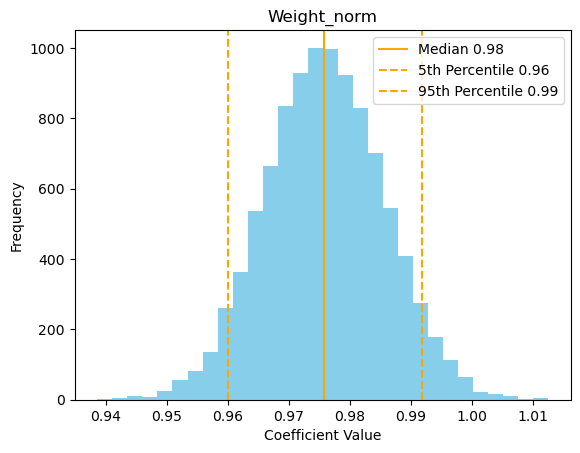

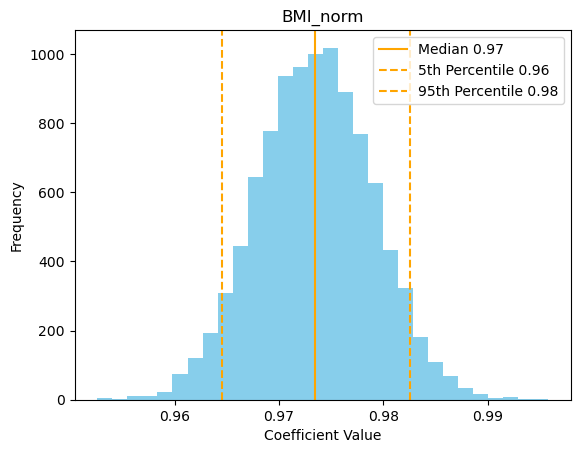

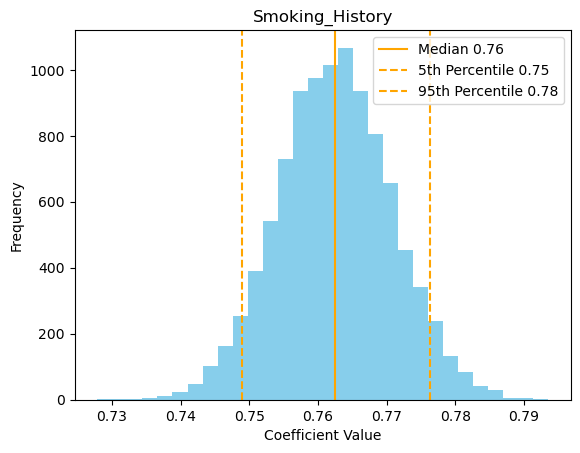

In [61]:
# plot the distribution of each coefficient to assess and interpret them
for name, i in zip(X_test.columns, range(simulated_betas_odds.shape[1])):
    plt.figure()
    plt.hist(simulated_betas_odds[:, i], bins=30, color='skyblue')
    plt.axvline(x = np.median(simulated_betas_odds, axis = 0)[i], color = 'orange', label = f'Median {np.median(simulated_betas_odds, axis = 0)[i]:.2f}')
    plt.axvline(x = np.percentile(simulated_betas_odds, 5, axis = 0)[i], color = 'orange', label = f'5th Percentile {np.percentile(simulated_betas_odds, 5, axis = 0)[i]:.2f}', linestyle = '--')
    plt.axvline(x = np.percentile(simulated_betas_odds, 95, axis = 0)[i], color = 'orange', label = f'95th Percentile {np.percentile(simulated_betas_odds, 95, axis = 0)[i]:.2f}', linestyle = '--')
    plt.title(f'{name}')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

### Interpretation of Coefficients

- The constant represents the baseline odds of having heart disease. This means that for a person with a poor or fair self perceived health status, who has not had a checkup in the past two years, who does not exercise, who does not have skin cancer or any other cancer, who does not have depression, who is not diabetic, who does not have arthritis, who is female, who is of average age, height, weight, and BMI, and who does not have a smoking history, the odds of having heart disease are 0.86 (0.83, 0.88). This indicates that the average person that falls into this category has a smaller chance of having heart disease than the chance of not having heart disease.

- For individuals who *do* exercise, the odds of having heart disease are 1.24 (1.21, 1.28) relative to those that do not. This means that

### Implementation of Principal Component Analysis (PCA)

## Find the amount of components needed to perform PCA with a specific percentage of variance kept.

In [62]:
from sklearn.decomposition import PCA

X = data.drop(columns='Heart_Disease')

# Percentage of variance that we want to keep, should be between 0 and 0.99
percentage = 0.95
components = 0

# simulate a do-while loop
while True:

    pca = PCA(n_components=components)
    pca.fit_transform(X)

    # if this is smaller than 0 we have kept at least percentage amount
    # of variance in the PCA.
    if percentage - sum(pca.explained_variance_ratio_[:components]) < 0:
        break

    components += 1

print(f'Number of components to use to keep {percentage * 100:.0f}% of the variance: {components}')

Number of components to use to keep 95% of the variance: 3


## The same procedure as above, but in a plot.

Number of components to use to keep 95% of the variance: 3


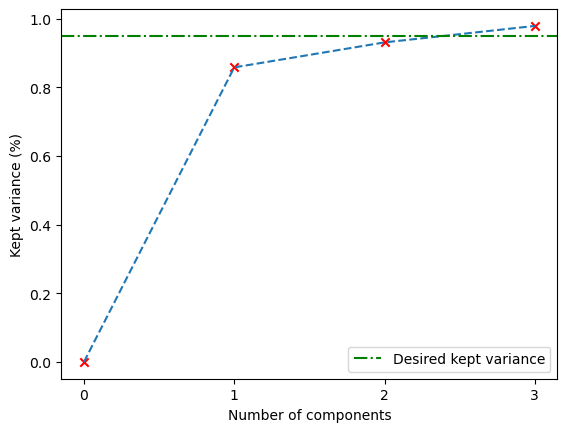

In [63]:
# Percentage of variance that we want to keep, should be between 0 and 0.99
percentage = 0.95
components = 0

# simulate a do-while loop
components = 0
ys = []
while True:

    pca = PCA(n_components=components)
    pca.fit_transform(X)

    # if this is smaller than 0 we have kept at least percentage amount
    # of variance in the PCA.
    ys.append(sum(pca.explained_variance_ratio_))
    if percentage - sum(pca.explained_variance_ratio_) < 0:
        break

    components += 1

print(f'Number of components to use to keep {percentage * 100:.0f}% of the variance: {components}')
plt.scatter(range(len(ys)), ys, marker='x', color='red')
plt.plot(range(len(ys)), ys, linestyle='--')
plt.xticks(range(len(ys)))
plt.axhline(percentage, color='green', linestyle='dashdot', label='Desired kept variance')
plt.xlabel('Number of components')
plt.ylabel('Kept variance (%)')
plt.legend()
plt.show()